In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
batch_size = 128
path = "./Datasets"

transform = transforms.ToTensor()

dataset = datasets.MNIST(root=path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=path, train=False, download=True, transform=transform)

# validacija ~ 10%
train_len = int(len(dataset) * 0.9)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
class Basic_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)

In [4]:
def train_autoencoder(model,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      device=None,
                      num_epochs=50
                      ):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        # TRAIN
        model.train()
        running_loss = 0.0
        running_error = 0.0
        n_samples = 0

        for x, _ in train_loader:
            x = x.to(device)
            batch_size = x.size(0)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_size
            # MAE error for the batch
            batch_error = torch.mean(torch.abs(out - x)).item()
            running_error += batch_error * batch_size
            n_samples += batch_size

        epoch_train_loss = running_loss / n_samples
        epoch_train_error = running_error / n_samples
        train_losses.append(epoch_train_loss)
        train_errors.append(epoch_train_error)

        # VALIDATION
        model.eval()
        val_running_loss = 0.0
        val_running_error = 0.0
        val_n = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                batch_size = x.size(0)
                out = model(x)
                loss = criterion(out, x)
                val_running_loss += loss.item() * batch_size
                batch_error = torch.mean(torch.abs(out - x)).item()
                val_running_error += batch_error * batch_size
                val_n += batch_size

        epoch_val_loss = val_running_loss / val_n
        epoch_val_error = val_running_error / val_n
        val_losses.append(epoch_val_loss)
        val_errors.append(epoch_val_error)

        tqdm.write(
            f"Epoch {len(train_losses)}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Train MAE: {epoch_train_error:.4f} | Val MAE: {epoch_val_error:.4f}")

    metrics = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_error": train_errors,
        "val_error": val_errors
    }

    torch.save(model.state_dict(), f"{model.__class__.__name__}_ep{num_epochs}.pth")
    torch.save(metrics, f"{model.__class__.__name__}_ep{num_epochs}_metrics.pth")

    return metrics

In [5]:
def plot_metrics(metrics, figsize=(10, 4)):
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_loss"], label="train")
    plt.plot(epochs, metrics["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Loss curve")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_error"], label="train")
    plt.plot(epochs, metrics["val_error"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("Reconstruction MAE")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Using device: cuda


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0426 | Val Loss: 0.0203 | Train MAE: 0.0983 | Val MAE: 0.0583
Epoch 2/50 | Train Loss: 0.0162 | Val Loss: 0.0134 | Train MAE: 0.0489 | Val MAE: 0.0426
Epoch 3/50 | Train Loss: 0.0120 | Val Loss: 0.0109 | Train MAE: 0.0393 | Val MAE: 0.0366
Epoch 4/50 | Train Loss: 0.0102 | Val Loss: 0.0096 | Train MAE: 0.0349 | Val MAE: 0.0336
Epoch 5/50 | Train Loss: 0.0091 | Val Loss: 0.0088 | Train MAE: 0.0324 | Val MAE: 0.0316
Epoch 6/50 | Train Loss: 0.0084 | Val Loss: 0.0082 | Train MAE: 0.0306 | Val MAE: 0.0302
Epoch 7/50 | Train Loss: 0.0078 | Val Loss: 0.0077 | Train MAE: 0.0293 | Val MAE: 0.0289
Epoch 8/50 | Train Loss: 0.0074 | Val Loss: 0.0074 | Train MAE: 0.0284 | Val MAE: 0.0281
Epoch 9/50 | Train Loss: 0.0071 | Val Loss: 0.0071 | Train MAE: 0.0276 | Val MAE: 0.0274
Epoch 10/50 | Train Loss: 0.0068 | Val Loss: 0.0069 | Train MAE: 0.0269 | Val MAE: 0.0269
Epoch 11/50 | Train Loss: 0.0066 | Val Loss: 0.0068 | Train MAE: 0.0264 | Val MAE: 0.0266
Epoch 12/50 | Train

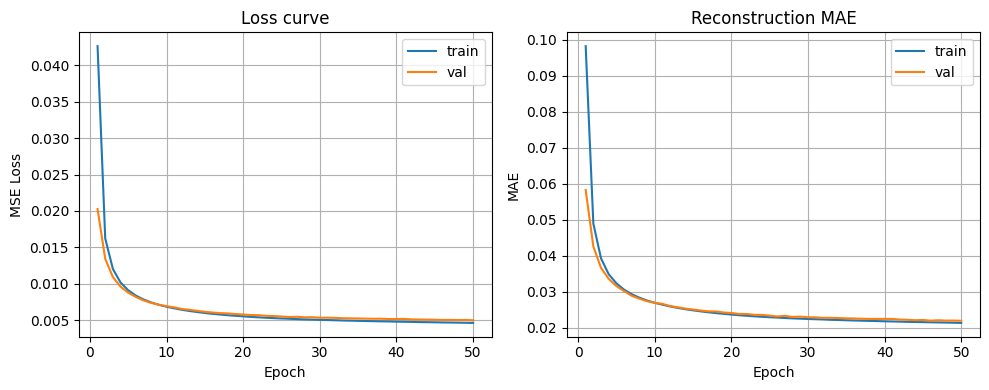

In [6]:
# Training the autoencoder

model = Basic_Autoencoder()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

metrics = train_autoencoder(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device=device,
    num_epochs=num_epochs,
    save_path="basic_autoencoder.pth"
)

plot_metrics(metrics)

In [7]:
def test_autoencoder(model,
                     test_loader,
                     criterion,
                     load_path,
                     show_examples=8,
                     device=None,
                     figsize=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)

    state = torch.load(load_path, map_location=device)
    model.load_state_dict(state)

    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    n_samples = 0

    first_batch_examples = None

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            batch_size = x.size(0)
            out = model(x)
            loss = criterion(out, x)
            mae = torch.mean(torch.abs(out - x))

            total_loss += loss.item() * batch_size
            total_mae += mae.item() * batch_size
            n_samples += batch_size

            if show_examples and first_batch_examples is None:
                first_batch_examples = (x.detach().cpu(), out.detach().cpu())

    avg_loss = total_loss / n_samples if n_samples else 0.0
    avg_mae = total_mae / n_samples if n_samples else 0.0

    metrics = {"test_loss": avg_loss, "test_mae": avg_mae}

    if show_examples and first_batch_examples is not None:
        x_cpu, out_cpu = first_batch_examples
        examples = min(show_examples, x_cpu.size(0))
        if figsize is None:
            figsize = (examples * 2, 4)
        fig, axes = plt.subplots(2, examples, figsize=figsize)
        for i in range(examples):
            axes[0, i].imshow(x_cpu[i].squeeze(), cmap="gray")
            axes[0, i].axis("off")
            if i == 0:
                axes[0, i].set_title("Original")
            axes[1, i].imshow(out_cpu[i].squeeze(), cmap="gray")
            axes[1, i].axis("off")
            if i == 0:
                axes[1, i].set_title("Reconstructed")
        plt.tight_layout()
        plt.show()

    return metrics

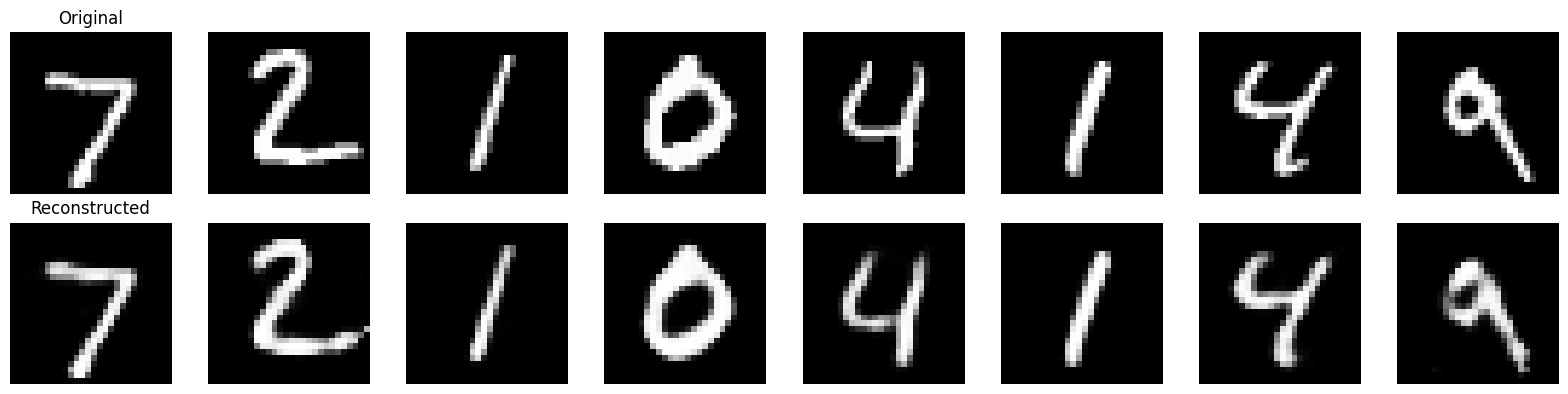

In [8]:
# Testing the autoencoder

test_criterion = nn.MSELoss()
test_metrics = test_autoencoder(
    model,
    test_loader,
    test_criterion,
    load_path="basic_autoencoder.pth",
    show_examples=8,
    device=device
)
